In [29]:
import pandas as pd
import os
from PIL import Image, ImageDraw
import pytesseract
import numpy as np
import sys
from tqdm import tqdm
import math

In [30]:
df = pd.DataFrame(columns=["Cat Number", "Site Number", "Locality", "Site", "Name", "Situation", "AccNum", "fileLocation"])

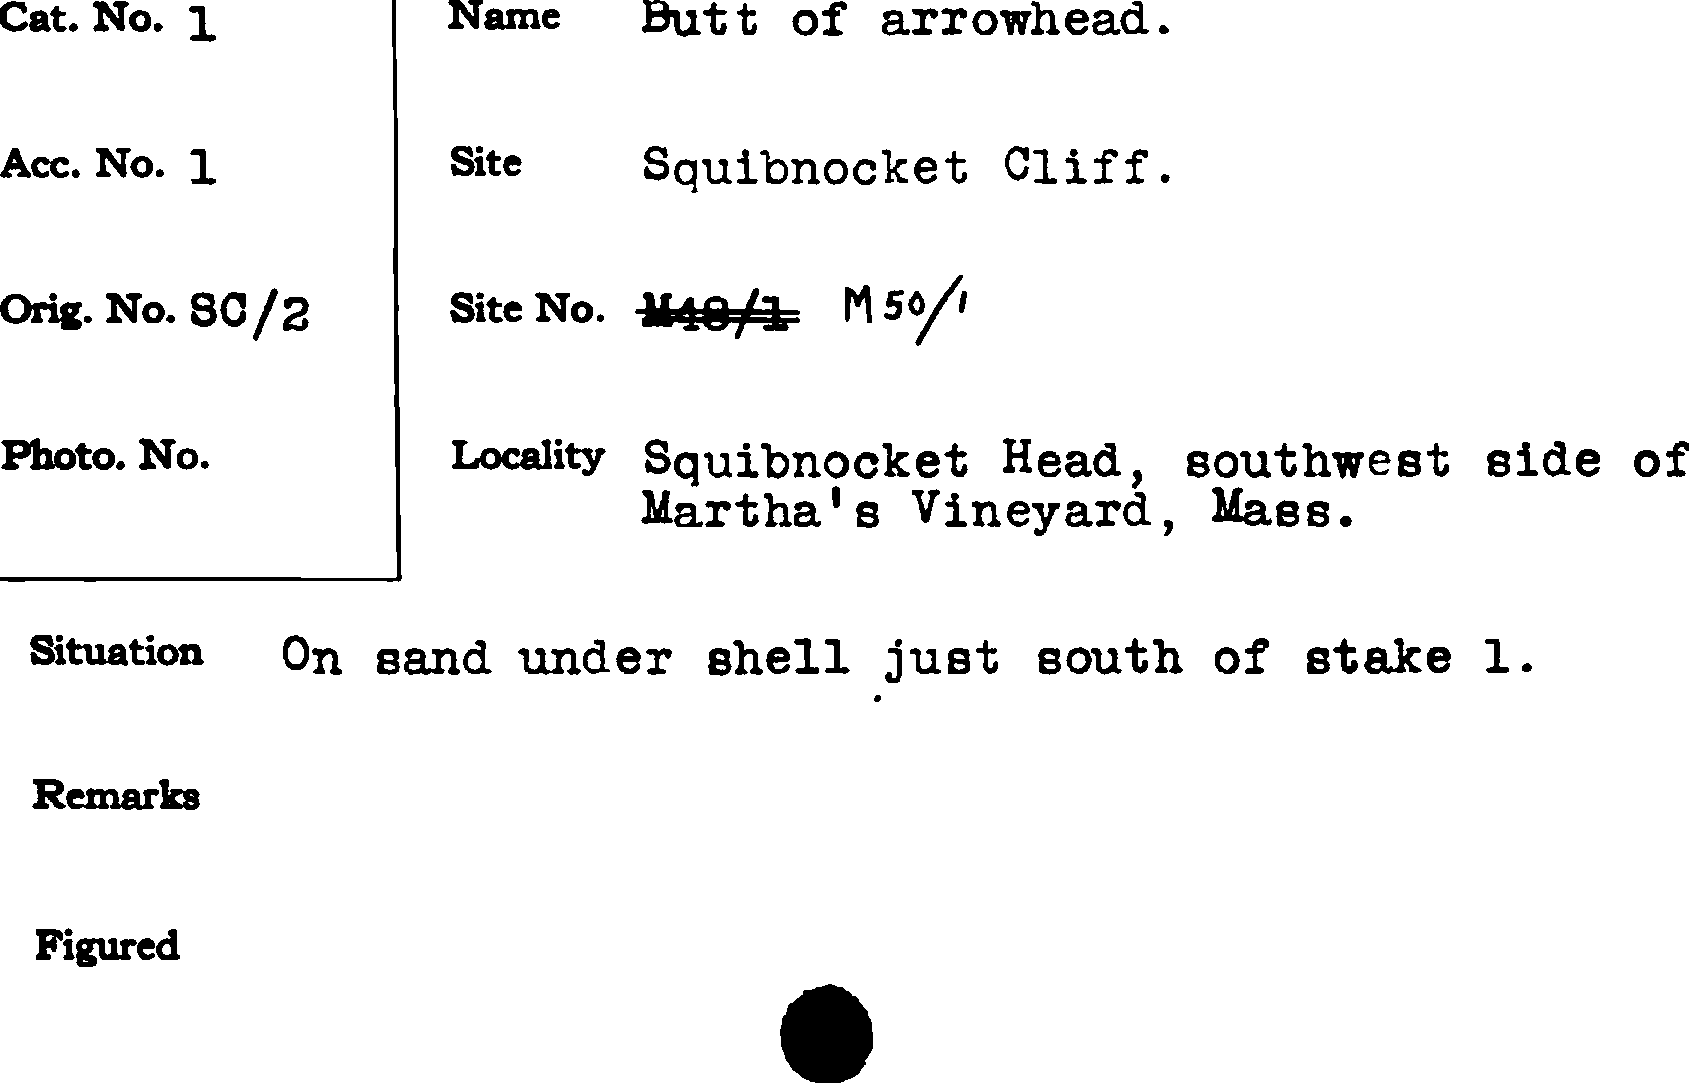

In [31]:
def bestLine(image, bMin,bMax, mMin, mMax, mStep=-1):
    if mStep == -1:
        mStep = (mMax-mMin)/20
    maxScore = 0
    maxB = -1
    maxM = -1
    for b in range(bMin, bMax, 3):
        for m in np.arange(mMin, mMax, mStep):
            score = 0
            momentum = 1
            for x in range(0, image.size[0]):
                y = int(m*x+b)
                if y > image.size[1] or x > image.size[0] or y < 1 or x < 1:
                    continue
                if image.getpixel((x, y)) == 0:
                    score += momentum
                    momentum += 1
                else:
                    momentum = 0
                    score -= 1
            if score > maxScore:
                maxScore = score
                maxB = b
                maxM = m
    if maxM == -1 or maxM == -1:
        print("ERROR")
        sys.exit()
    return maxB, maxM

##I"M SORRY FOR THE CODE REUSE!!!!!!

def cropLeft(bw):
    xSize=bw.size[0]
    ySize=bw.size[1]
    tol=20
    # Crop left
    for x in range(0, int(xSize/10)):
        pixSum = 0
        for y in range(0, ySize):
#             print(bw.getpixel((x, y)))
            if bw.getpixel((x, y)) == 0:
                pixSum += 1
            if pixSum > tol:
                return bw.crop((x, 0, xSize, ySize))
            
def cropRight(bw):
    xSize=bw.size[0]
    ySize=bw.size[1]
    tol=3
    # Crop Right
    for x in range(xSize-1, int(5*xSize/10), -1):
        pixSum = 0
        for y in range(0, ySize):
#             print(bw.getpixel((x, y)))
            if bw.getpixel((x, y)) == 0:
                pixSum += 1
            if pixSum > tol:
                return bw.crop((0, 0, x, ySize))
            
def cropTop(bw):
    xSize=bw.size[0]
    ySize=bw.size[1]
    tol=20
    # Crop left
    for y in range(0, int(ySize/10)):
        pixSum = 0
        for x in range(0, xSize):
            if bw.getpixel((x, y)) == 0:
                pixSum += 1
            if pixSum > tol:
                return bw.crop((0, y, xSize, ySize))
            
def cropBottom(bw):
    xSize=bw.size[0]
    ySize=bw.size[1]
    tol=20
    # Crop left
    for y in range(ySize-1, int(9*ySize/10), -1):
        pixSum = 0
        for x in range(0, xSize):
            if bw.getpixel((x, y)) == 0:
                pixSum += 1
            if pixSum > tol:
                return bw.crop((0, 0, xSize, y))
def rectifyImage(image):
    gray = image.convert('L')
    xSize=image.size[0]
    ySize=image.size[1]
    #Convert to black and white
    bw = gray.point(lambda x: 0 if x<200 else 255, '1')
    # Rotate image
    b, m = bestLine(bw, 500, 700, -.05, .05)
    deg = math.degrees(math.sin(abs(m*xSize)/xSize))
    bw = bw.rotate(-deg, expand=True)
    # Crop sides
    bw = cropLeft(bw)
    bw = cropRight(bw)
    bw = cropTop(bw)
    bw = cropBottom(bw)
    return bw
    
rectifyImage(Image.open("" + os.getcwd() + "/peabody_files/Accession Files/1/1_0001.pdf.png"))

In [ ]:
images = []
i = 0
configArgs = 'config="-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz.:!, -psm 6"'
for folder in os.listdir("peabody_files/Accession Files/"):
    try:
        if '.DS_Store' in folder:
            continue
        if int(folder) in [1, 100, 101, 102, 103, 104, 105,106,107, 108, 16, 17, 18, 2, 20, 21, 22, 23, 24, 25]:
            print("skipped folder " + folder)
            continue
        Image.open("peabody_files/Accession Files/"+folder+"/"+list(os.listdir("peabody_files/Accession Files/"+folder))[0]).show()
        site_no=input("Please enter site number: ")
        for file in os.listdir("peabody_files/Accession Files/"+folder):
            if 'DS_Store' in file:
                continue
            print(str(''.join(['-' for x in range(10)])), '\n')
            fileLocation = "peabody_files/Accession Files/"+folder+'/'+file
            print("File", fileLocation)
            img = Image.open(fileLocation)
            img = rectifyImage(img)
            xSize=img.size[0]
            ySize=img.size[1]
            catNumber = file[-12:-8]
            accNumber = file[0:file.index("_")]
            localityImg = img.crop((450, 400, xSize-450, 640))
            siteImg = img.crop((440,150, xSize-440, 250))
            nameImg = img.crop((440,5, xSize-440, 100))
            situationImg = img.crop((25,635, xSize-25, 735))

            locality = pytesseract.image_to_string(localityImg, config=configArgs)
            site = pytesseract.image_to_string(siteImg, config=configArgs)
            situation = pytesseract.image_to_string(situationImg, config=configArgs)
            name = pytesseract.image_to_string(nameImg, config=configArgs)
            print("Cat Number:", catNumber)
            print("Site Number:", site_no)
            print("Locality:", locality)
            print("Site:", site)
            print("Name:", name)
            print("Situation:", situation)
            print("ACC#:", accNumber)
            df.loc[len(df)]=[catNumber, site_no, locality, site, name, situation, accNumber, fileLocation]
    except:
        print("error at folder " + folder)

skipped folder 1
skipped folder 100
skipped folder 101
skipped folder 102
skipped folder 103
skipped folder 104
skipped folder 105
skipped folder 106
skipped folder 108
skipped folder 16
skipped folder 17
skipped folder 18
skipped folder 2
skipped folder 20
skipped folder 21
skipped folder 22
skipped folder 23
skipped folder 24
skipped folder 25
Please enter site number: 
---------- 

File peabody_files/Accession Files/26/26_4034.pdf.png
Cat Number: 4034
Site Number: 
Locality: Locality Scene of Pontiao's :1
Detroit.
Site: Site
Name: Name Head Of tonahawk.
Situation: Situation
ACC#: 26
Please enter site number: 
---------- 

File peabody_files/Accession Files/27/27_4035.pdf.png
Cat Number: 4035
Site Number: 
Locality: Locality Lafayette 00., Arkana
Site: Site L.A. Foster Place .
Name: Name Pottery vessel.
Situation: Situation Hound .
ACC#: 27
---------- 

File peabody_files/Accession Files/27/27_4036.pdf.png
Cat Number: 4036
Site Number: 
Locality: Locality Lafayette Co. , A
Site: Site

Cat Number: 4070
Site Number: 
Locality: Locality Coast Islands, Califc
Site: Site
Name: Name Sinker .
Situation: Situation
ACC#: 28
---------- 

File peabody_files/Accession Files/28/28_4071.pdf.png
Cat Number: 4071
Site Number: 
Locality: :ocality Coast and Islands, (1
Site: Site
Name: Name Chart drill .
Situation: ituation
ACC#: 28
---------- 

File peabody_files/Accession Files/28/28_4072.pdf.png
Cat Number: 4072
Site Number: 
Locality: Locality Coast and Islands, 0:
Site: Site
Name: Name Chart (12111 0
Situation: Situation
ACC#: 28
---------- 

File peabody_files/Accession Files/28/28_4073.pdf.png
Cat Number: 4073
Site Number: 
Locality: Locality Coast and Islands, Os.
Site: Site
Name: Name Chart drill .
Situation: Situation
ACC#: 28
---------- 

File peabody_files/Accession Files/28/28_4074.pdf.png
Cat Number: 4074
Site Number: 
Locality: Locality Coast and Islands, 05
Site: Site
Name: Name Chart drill.
Situation: Situation
ACC#: 28
---------- 

File peabody_files/Accession Files

Cat Number: 4110
Site Number: 
Locality: gocality Gal ifornia. .
Site: Site
Name: Name Pottery water 311:, 1
cahuilla.
Situation: ituation
ACC#: 28
---------- 

File peabody_files/Accession Files/28/28_4111.pdf.png
Cat Number: 4111
Site Number: 
Locality: Locality Toro, Colorado Desert
Site: Site
Name: Name 2 pot shards .
Situation: Situation
ACC#: 28
---------- 

File peabody_files/Accession Files/28/28_4112.pdf.png
Cat Number: 4112
Site Number: 
Locality: meality Lost Horse Valley. 05
Site: Site
Name: Name 8 potsherds .
Situation: ituation
ACC#: 28
---------- 

File peabody_files/Accession Files/28/28_4113.pdf.png
Cat Number: 4113
Site Number: 
Locality: Locality Pt. Happy, California
Site: Site
Name: —

Name 16 pot shards .
Situation: Situation
ACC#: 28
---------- 

File peabody_files/Accession Files/28/28_4114.pdf.png
Cat Number: 4114
Site Number: 
Locality: Locality California Desert.
Site: Site
Name: Name 31 p01; shards .
Situation: Situation
ACC#: 28
---------- 

File peabody_fi

Cat Number: 0511
Site Number: Me.152/1
Locality: Locality Bluehi]
Site: Site

Nevin 3'
Name: Name P011 Sh1'
Situation: Situation Trench 10.3, Section 3E. In shell
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0512.pdf.png
Cat Number: 0512
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin' Shell Heap.
Name: Name Hammer stone.
Situation: Situatim Trench 1137.1, Section 3E. Below shell in brown
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0513.pdf.png
Cat Number: 0513
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap .
Name: Name 3 hammerstones.
Situation: Situation Trench 10.3, Section 3E. From pit below shells.
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0514.pdf.png
Cat Number: 0514
Site Number: Me.152/1
Locality: l Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap .
Name: Name Plummet .
Situation: 5mm” Trench IC.3, Section 3E. In humus below shell.
ACC#: 3
---------- 

Cat Number: 0542
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap.
Name: Name Pot shards, roulette d
Situation: Situation Trench ID.1, Section 3E. In ash among shells.
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0543.pdf.png
Cat Number: 0543
Site Number: Me.152/1
Locality: | LocalitEv Bluehill Falls, Me.
Site: Site Nevin Shell Heap .
Name: Name Iodern Jackknife.
Situation: Situation Trench IC.4, Section 3E. 8 cm. below top of she]
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0544.pdf.png
Cat Number: 0544
Site Number: Me.152/1
Locality: J Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap .
Name: Name 2 hammer stones.
Situation: Situation In shells. Trench ID.2, Section 4E.
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0545.pdf.png
Cat Number: 0545
Site Number: Me.152/1
Locality: | Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap.
Name: Name 1 broken opyppeq pognzt
Situation: Shari“! T0]: 

Cat Number: 0572
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap.
Name: Name ranged arrowpoint.
Situation: Situation Trench 10.2, Section 413. Below shell and pebble:
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0573.pdf.png
Cat Number: 0573
Site Number: Me.152/1
Locality: ‘ Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap .
Name: Name Top of broken plummet.
Situation: Situation Trench IC.2, Section 4E. In black pebbles and
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0574.pdf.png
Cat Number: 0574
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap.
Name: Name Base of square-butted
Situation: Situation :I‘rench I022, Section 4E. In black pebbles and
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0575.pdf.png
Cat Number: 0575
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap.
Name: Name Broken-bone awl.
Situation: Situati

Cat Number: 0603
Site Number: Me.152/1
Locality: J Locality Bluehill Falls, Me.
Site: Site Nevin shell heap.
Name: Name Piece of broken harpoc
Situation: Situation Trench 10.4, Section 433.
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0604.pdf.png
Cat Number: 0604
Site Number: Me.152/1
Locality: | Locality Bluehill Falls, Me.
Site: Site Nevin Shell Hear).
Name: Name Broken arrowhead.
Situation: Situation Trench ID.2. Section 5E.
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0605.pdf.png
Cat Number: 0605
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap .
Name: Name Quartz lacraper.
Situation: Situation Trench 113.2, Section 5E. Just under sod.
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0606.pdf.png
Cat Number: 0606
Site Number: Me.152/1
Locality: ’ Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap.
Name: Name 0811: .
Situation: Situation Trench ID. 2 Section 5E. In shells (below shell
of R H. 5E

Cat Number: 0634
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap.
Name: Name Knife.
Situation: Situation Stake moved IC.3, Section 5E. In plowed shell.
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0635.pdf.png
Cat Number: 0635
Site Number: Me.152/1
Locality: l Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap .
Name: Name Broken knife .
Situation: Situation Trench IC.2, Section 5E. In shell below plow
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0636.pdf.png
Cat Number: 0636
Site Number: Me.152/1
Locality: Site No. Me.152/1

Locality Bluehill Falls, Me.
Site: 
Name: 
Situation: 
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0637.pdf.png
Cat Number: 0637
Site Number: Me.152/1
Locality: Site No. Me . 153/1

Locality Bluehill Falls, Me.
Site: 
Name: 
Situation: 
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0638.pdf.png
Cat Number: 0638
Site Number: Me.152/1
Locality: Site No. Me . 15

Cat Number: 0669
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap.
Name: Name Oye’o er shell.
Situation: Situation French $C.S,.Secyion _5E. Below plow line under

*4
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0670.pdf.png
Cat Number: 0670
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap .
Name: Name Hump-backed scraper .
Situation: Situation Trench 113.1, Section 6E, N-W. corner. Pocket of
shell and Eravel.
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0671.pdf.png
Cat Number: 0671
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap .
Name: Name Crude tip of broken kn
Situation: Situation Trench ID.1, Section 6E. N.W. corner. Pocket
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0672.pdf.png
Cat Number: 0672
Site Number: Me.152/1
Locality: Site No. Me, 152/1

Locality Bluehill Falls, Me.
Site: name quartz hammer 8170116.
Name:

Cat Number: 0701
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin Sh e11 Heap .
Name: Name Portion of bone awl.
Situation: Situation Trench ID.1, Section 6E. N.W. corner. Near tap
of shell.
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0702.pdf.png
Cat Number: 0702
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap -
Name: Name Point of broken bone a
Situation: Situation Found while peeling sod at about Trench ID”)
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0703.pdf.png
Cat Number: 0703
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin ShEll Heap‘
Name: Name Beaver tooth.
Situation: Situation Trench ID.1, Section 6E. In top of shell.
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0704.pdf.png
Cat Number: 0704
Site Number: Me.152/1
Locality: [4th Bluehill Falls, M
Site: Site Nevin Shell Heap.
Name: Name Awl made of rib.
Situation: Situatim‘ Trench 10

Cat Number: 0731
Site Number: Me.152/1
Locality: I Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap.
Name: Name Broken gouge.
Situation: Situation Trench IC._3,_§ection 7E. In humus below 8nd
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0732.pdf.png
Cat Number: 0732
Site Number: Me.152/1
Locality: Locality Bluehill Fall
Site: Site Nevin Shell H
Name: Name Adze.
Situation: Situation Trench IC.4, Section 713. In black humus
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0733.pdf.png
Cat Number: 0733
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap.
Name: i Name Jasper thumb scraper.
Situation: Situation Trench 10.4, Section 7E. In shell.
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0734.pdf.png
Cat Number: 0734
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap .
Name: Name Slate fragment of be
Situation: Situatim Trench ID/7E (stake). 410m. from top of heap i:

Cat Number: 0761
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap .
Name: Name Fragment of bone pikeh
Situation: Situation IC.3/7E(stake). In black humus.
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0762.pdf.png
Cat Number: 0762
Site Number: Me.152/1
Locality: \
Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap.
Name: Name Drilled bone harpoon.
Situation: Situation Trench 10.2, Section 7E. First layer of shells.
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0763.pdf.png
Cat Number: 0763
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap .
Name: Name Piece of human femur.
Situation: Situation Trench 10.2, Section 7E. First layer of shells
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0764.pdf.png
Cat Number: 0764
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me
Site: Site Nevin Shell Heap.
Name: Name Butt of bone awl.‘
Situation: Situation Trench 10

Cat Number: 0790
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap .
Name: Name Pot sherds .
Situation: Situation Trench 10.1, Section 7E. In 2nd la er of shells
30cm. below ton of heap from 13.1/7 .
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0791.pdf.png
Cat Number: 0791
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap.
Name: Name Pot sherds .
Situation: Situation Trench 10.2, Section 7E. lst shell layer.
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0792.pdf.png
Cat Number: 0792
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin Sh ell Heap .
Name: Name Pot sherda.
Situation: Situation Trench 10.8, Section 7E. In shells just below
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0793.pdf.png
Cat Number: 0793
Site Number: Me.152/1
Locality: . Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap.
Name: Name Broken blank for adze
Situati

Cat Number: 0822
Site Number: Me.152/1
Locality: Locality Bluehi]
Site: Site Nevin S
Name: Name Scraper
Situation: Situatim Trench 10.3, Section 8E. In shell
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0823.pdf.png
Cat Number: 0823
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap.
Name: Name Base of fish tail arro
Situation: Situation Trench 10.5, Section 8E. In lowest shell.
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0824.pdf.png
Cat Number: 0824
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap .
Name: Name Hammer stone.
Situation: Situation Trench IC.3, Section 8E. In lower shell below
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0825.pdf.png
Cat Number: 0825
Site Number: Me.152/1
Locality: Locality Bluehill Falls, ”8.
Site: Site Nevin Shell Heap.
Name: Name Large plummet.
Situation: Situation Trench I“.1, Section 8E. 39cm. from top of hea
in black humus.
AC

Cat Number: 0852
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap.
Name: Name Unfinished celt .
Situation: swim“ Trench 10-1. Section 8E. In black hmmm n'nﬂ
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0853.pdf.png
Cat Number: 0853
Site Number: Me.152/1
Locality: J Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap.
Name: Name Broken plummet .
Situation: Situation Trench 10.1, Section 8E. In 2nd level of rock
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0854.pdf.png
Cat Number: 0854
Site Number: Me.152/1
Locality: ' Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap.
Name: Name Broken gouge or adze ‘:
Situation: Situation Trench 7107.}, Section 8E. In pebbles and humus
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0855.pdf.png
Cat Number: 0855
Site Number: Me.152/1
Locality: I Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap.
Name: %—
Nm° Chipped knife.
Situation: Sham“ Trench 13-1. 

Cat Number: 0882
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me
Site: Site Nevin Shell Heap.
Name: Name Piece Of SWOI‘d Of E
Situation: Situation Trench 10.8, Section 8E. In humus and pebble
in rock complex.
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0883.pdf.png
Cat Number: 0883
Site Number: Me.152/1
Locality: LocalityBluehill Falls, ME.
Site: Site Nevin Shel l Heap -
Name: Name Tip of harpoon.
Situation: I Situation Trench 10.2, Section 8E. Among; rocks in humus.
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0884.pdf.png
Cat Number: 0884
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap .
Name: Name Piece of sword of awe:
Situation: SituatiOn Trench IC.2, Section 8E. Among: rocks in humus
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0885.pdf.png
Cat Number: 0885
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap .
Name: Name Bone point .
Situation: S

Cat Number: 0913
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap.
Name: Name Thumb scraper (jasper)
Situation: Situation Trench 10.4, Section 9E. On top of shell.
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0914.pdf.png
Cat Number: 0914
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap .
Name: Name Polishing stone.
Situation: Situation Trench 10.4, Section 9E. In upper part of shell
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0915.pdf.png
Cat Number: 0915
Site Number: Me.152/1
Locality: Locality Bluehill Fells, Me.
Site: Site Nevin Shell Heap.
Name: Name Butt of large knife.
Situation: Simﬁm Trench 10.13, Section 9E. Upper level of shell.
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0916.pdf.png
Cat Number: 0916
Site Number: Me.152/1
Locality: Locality 13111811111 Falls, Me.
Site: Site Nevin Shell Heap .
Name: Name Scraper.
Situation: Situaﬁm Trench 16.4, Secti

Cat Number: 0943
Site Number: Me.152/1
Locality: Locality Bluehill Falls, lie.
Site: Site Nevin Shel 1 Heap.
Name: Name Broken gouge .
Situation: Situation Trench 10.2, Section 9E. In black pebbles.
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0944.pdf.png
Cat Number: 0944
Site Number: Me.152/1
Locality: Locality Blueh 11
Site: Site Nevin S
Name: Name Broken
Situation: Situation Trench 10.2, Section 9E. In shell
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0945.pdf.png
Cat Number: 0945
Site Number: Me.152/1
Locality: Locality Bluemn Falls, Me.
Site: Site Nevin Shell Heap.
Name: Name [108.
Situation: Situation Trench 10.2, Section 9E. Under layer of pebble
1n humus.
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0946.pdf.png
Cat Number: 0946
Site Number: Me.152/1
Locality: Locality Bluehill Fa
Site: Site Nevin Shell
Name: Name Large plumm
Situation: Situation Trench IC.1, Section 9E. Under shells
ACC#: 3
---------- 

File peabody_files/Accessio

Cat Number: 0974
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap.
Name: i Name Potaberda.
Situation: Situﬁﬁm Trench 16.22, Section 9E. In shells.
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0975.pdf.png
Cat Number: 0975
Site Number: Me.152/1
Locality: Locality Bluehill Falls, He.
Site: Site Nevin Shell Heap.
Name: Name Pot shards.
Situation: SimﬁOn Trench 10.2, Section 9E. In shells.
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0976.pdf.png
Cat Number: 0976
Site Number: Me.152/1
Locality: ’ Locality Bluehill Falls, [6.
Site: Site Nevin Shell Heap.
Name: Name Potsherda.
Situation: Situaﬁm Trench 10.2, Section 9E. Second peel.
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0977.pdf.png
Cat Number: 0977
Site Number: Me.152/1
Locality: Locality Blue
Site: Site

Nevi
Name: Name I’Otﬂ
Situation: Situation Trench 10.4, Section 92E.
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_0978.pdf.png
Cat N

Cat Number: 1008
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site Nevin Shell Heap.
Name: Name Butt of adze (‘3)
Situation: Situaﬁm Surface .
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_1009.pdf.png
Cat Number: 1009
Site Number: Me.152/1
Locality: Locality Blushill Falls, Me.
Site: Site Nevin Shell Heap.
Name: Name Edge of polished slate
Situation: Simﬁm Surface .
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_1010.pdf.png
Cat Number: 1010
Site Number: Me.152/1
Locality: Locality B1ueh111 Falls, Me.
Site: Site Nevin Shell Heap.
Name: 1“” Large plummet .
Situation: Situation On beach, surface.
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_1011.pdf.png
Cat Number: 1011
Site Number: Me.152/1
Locality: Locality Bluehill Falls, Me.
Site: Site

Nevin Shell Heap.
Name: Nam Point of large broken
Situation: Situation Sod ,
ACC#: 3
---------- 

File peabody_files/Accession Files/3/3_1012.pdf.png
Cat Number: 1012
Site Number: Me.15

Cat Number: 4151
Site Number: 
Locality: Locaiity Southern Oregon.
Site: Site
Name: Name Obsidian aide scraper
Situation: Situation
ACC#: 30
---------- 

File peabody_files/Accession Files/30/30_4152.pdf.png
Cat Number: 4152
Site Number: 
Locality: Locality Southern Oregon.
Site: Site
Name: Name Obsidian aide scraper
Situation: Situation
ACC#: 30
---------- 

File peabody_files/Accession Files/30/30_4153.pdf.png
Cat Number: 4153
Site Number: 
Locality: Locality Southern Oregon
Site: Site
Name: Name

Obsidian side 81
Situation: Situation
ACC#: 30
---------- 

File peabody_files/Accession Files/30/30_4154.pdf.png
Cat Number: 4154
Site Number: 
Locality: Locality Southern Oregon.
Site: Site
Name: Name Obsidian side scraper
Situation: Situation
ACC#: 30
---------- 

File peabody_files/Accession Files/30/30_4155.pdf.png
Cat Number: 4155
Site Number: 
Locality: mality Southern Oregon.
Site: Site
Name: Name Obsidian side scraper
Situation: ituation
ACC#: 30
---------- 

File peabody_files/Acc

Cat Number: 4191
Site Number: 
Locality: .ocality Southern Oregon .
Site: Site
Name: Name Obsidian end scraper.
Situation: ituation
ACC#: 30
---------- 

File peabody_files/Accession Files/30/30_4192.pdf.png
Cat Number: 4192
Site Number: 
Locality: .ocality Southern Oregon .
Site: Site
Name: Name Obsidian end scraper .
Situation: ituation
ACC#: 30
---------- 

File peabody_files/Accession Files/30/30_4193.pdf.png
Cat Number: 4193
Site Number: 
Locality: Locality Southern Oregon.
Site: Site
Name: Name Obsidian and scraper.
Situation: Situation
ACC#: 30
---------- 

File peabody_files/Accession Files/30/30_4194.pdf.png
Cat Number: 4194
Site Number: 
Locality: Locality Southern Oregon.
Site: Site
Name: Name Obsidian end scraper.
Situation: Situation
ACC#: 30
---------- 

File peabody_files/Accession Files/30/30_4195.pdf.png
Cat Number: 4195
Site Number: 
Locality: .ocality Southern Oregon
Site: Site
Name: Name 011a]. cedony end I
Situation: ituation
ACC#: 30
---------- 

File peabody_file

Cat Number: 4231
Site Number: 
Locality: '.oca1ity Southern Orego
Site: Site
Name: Name Obs 1d 18.11 spean
Situation: ituation
ACC#: 30
---------- 

File peabody_files/Accession Files/30/30_4232.pdf.png
Cat Number: 4232
Site Number: 
Locality: Locality Southern Oregon.
Site: Site
Name: Name 0b 8 16.18.11 spearpo int .
Situation: imation
ACC#: 30
---------- 

File peabody_files/Accession Files/30/30_4233.pdf.png
Cat Number: 4233
Site Number: 
Locality: Locality Southern Oregon.
Site: Site
Name: Name Ohalc edony spearpoint
Situation: Situation
ACC#: 30
---------- 

File peabody_files/Accession Files/30/30_4234.pdf.png
Cat Number: 4234
Site Number: 
Locality: gocality Southern Oregon.
Site: Site
Name: Name Chaloedony apearp01m;
Situation: ituation
ACC#: 30
---------- 

File peabody_files/Accession Files/30/30_4235.pdf.png
Cat Number: 4235
Site Number: 
Locality: ".ocality Southern Oregon
Site: Site
Name: Name Chipped disc?
Situation: ituation
ACC#: 30
---------- 

File peabody_files/Acces

Cat Number: 4269
Site Number: Me.152/7
Locality: Locality Bluebill , Maine .
Site: Site Richards Shell Heap.
Name: Name Arrowpoint .
Situation: SituatiOn Trench 1.2. Section 11:. Ton of lame broken
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4270.pdf.png
Cat Number: 4270
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap.
Name: Name Hameratone.
Situation: SimatiOn Trench 1.3, Sectign IE,_ Large broken shell and
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4271.pdf.png
Cat Number: 4271
Site Number: Me.152/7
Locality: Locality 3111911111 , Maine .
Site: Site Richards Shell Heap .
Name: Name Base of knife.
Situation: Situation Trench 1.3, Section 1E. Disturbed shell layer

__-__A| _n 7
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4272.pdf.png
Cat Number: 4272
Site Number: Me.152/7
Locality: Locality Bluehnl , Maine .
Site: Site Richards Shell Heap.
Name: Name LIIO'DO int .
Situation: Sham“. Tren

Cat Number: 4298
Site Number: Me.152/7
Locality: .ocality Blush 111 , Maine .
Site: Site Richards Shell Heap.
Name: Name Fragment of 'hot stonl
Situation: imation Trench IB.1, Section IE. Broken shell and humus
plow disturbed layer.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4299.pdf.png
Cat Number: 4299
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap.
Name: Name Fragment of spearpozlnt
Situation: Situation Trench 18.1, Section 1E. Bottom of broken shell
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4300.pdf.png
Cat Number: 4300
Site Number: Me.152/7
Locality: mality 3111811111 , Maine .
Site: Site Richards Shell Heal
Name: Name at 1.1 129d 0111p .
Situation: imation Trench 18.1, Section 11“... P101! disturbed laws
under “lower sod".
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4301.pdf.png
Cat Number: 4301
Site Number: Me.152/7
Locality: Locality 3111811111, Maine.
Site: Site

Richards Sh

Cat Number: 4327
Site Number: Me.152/7
Locality: Locality Blush 111 , Maine .
Site: Site Richards Shell Heap.
Name: Name Barbed. bone narpoon.
Situation: ituation Trench n.3, Section 11:. Hearth in east wall.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4328.pdf.png
Cat Number: 4328
Site Number: Me.152/7
Locality: Locality 3111811111 , Maine .
Site: Site Richards Shell Heap.
Name: Name Fragment or bone at]
Situation: imation Trench n.3, Section 1E. T111 beneath hearth t
east wall.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4329.pdf.png
Cat Number: 4329
Site Number: Me.152/7
Locality: Locality Bluehill , Maine
Site: Site Richards Shell 1
Name: Name Worked bone .
Situation: imation Trench IB, Section 1E. Finely broken ahel
above ash layer III.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4330.pdf.png
Cat Number: 4330
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell He
Name: Name Fragment Of '0 He

Cat Number: 4356
Site Number: Me.152/7
Locality: Locality Bluebill , Maine .
Site: Site Richards Shell Heap .
Name: Name Pot shards .
Situation: Situation Trench IA, Section 1E. Plow disturbed shell
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4357.pdf.png
Cat Number: 4357
Site Number: Me.152/7
Locality: Localitsﬂluehill , Maine.
Site: Site

Richards Shell Heap.
Name: I Name Pottery.
Situation: Situatim Trench IA, Section 1E. Black humus and shell.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4358.pdf.png
Cat Number: 4358
Site Number: Me.152/7
Locality: :ocaiity Bluehill, Maine.
Site: Site Richards Shell Heap.
Name: Name Pot enema .
Situation: imam“ Trench IA, Section 113. Humus layer.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4359.pdf.png
Cat Number: 4359
Site Number: Me.152/7
Locality: Locality 13111911111 , Maine .
Site: Site Richards Shell Heap.
Name: Name Potsherde .
Situation: Situatim Trench IA, Section 113. Burned shell l

Cat Number: 4386
Site Number: Me.152/7
Locality: ‘ Locality Bluehill, Maine.
Site: Site Richards Shell Heap.
Name: Name Arrowpoint .
Situation: Sham“ Trench 1.1, Section 8E. Fine broken shell
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4387.pdf.png
Cat Number: 4387
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap .
Name: Name Adze blank .
Situation: Situatim‘ Trench 1.1, Section 2:. Fine broken shell and
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4388.pdf.png
Cat Number: 4388
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap .
Name: Name Turtle back.
Situation: Situation Trench 1.1, sectign an. VFine broken shell,
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4389.pdf.png
Cat Number: 4389
Site Number: Me.152/7
Locality: mality Bluehill , Maine .
Site: Site Richards Shell Hen}
Name: Name Knife .
Situation: imam” Trench I.1, Section 2E. Broken shell, 

Cat Number: 4416
Site Number: Me.152/7
Locality: Site No. no. 152/ 7

Locality Bluehill , Maine .
Site: --—'- v- wry- .
Name: 
Situation: 
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4417.pdf.png
Cat Number: 4417
Site Number: Me.152/7
Locality: Site No. Me . 152/?

Locality Bluehill , Kaine .
Site: — -—..--

0&LuwyULuh.
Name: 
Situation: 
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4418.pdf.png
Cat Number: 4418
Site Number: Me.152/7
Locality: Site No. Me . 153/7

Locality Bluehill , Maine .
Site: U - -‘n‘ HUB

“I‘ll.
Name: 
Situation: 
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4419.pdf.png
Cat Number: 4419
Site Number: Me.152/7
Locality: Site No. Me . 152/7

Locality Bluehill , Maine .
Site: -——-U-V-V"UIL .
Name: 
Situation: 
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4420.pdf.png
Cat Number: 4420
Site Number: Me.152/7
Locality: Site No. Me . 1552/7

Locality Bluehi 11 , Maine .
Site: """ gnu-iv uvdﬂiywi O
N

Cat Number: 4453
Site Number: Me.152/7
Locality: '.ocality Bluehill , Maine .
Site: Site Richards Shell Heap .
Name: Name quartz scraper .
Situation: imatiOn Trench 13.2, Section 21:. Broken shells and human;
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4454.pdf.png
Cat Number: 4454
Site Number: Me.152/7
Locality: Locality 3111611111, "8.1116.
Site: Site R1 chards Shell Heap .
Name: Name R91 601: .
Situation: Situatim Trench 18.2, Section 22. Broken shell and humus,
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4455.pdf.png
Cat Number: 4455
Site Number: Me.152/7
Locality: Locality Bluehill , Maine.
Site: Site

R1 charda Shell Heap.
Name: Nam: Thumb BO rape: .
Situation: Situation :I'renoh I843, Sgotion 2E. Large broken shell and
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4456.pdf.png
Cat Number: 4456
Site Number: Me.152/7
Locality: .ocality Bluehnl , Maine .
Site: Site Richards Shell Heap .
Name: Name Fragment Of arrowpo 1m
Situati

Cat Number: 4482
Site Number: Me.152/7
Locality: Locality Blush 111 , Maine .
Site: Site

Richards Shell Heap .
Name: _ __

Name Beaver tooth chisel.

 

s
Situation: Situatim Treych n.3,usection 3E. At bottom of 191: char-
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4483.pdf.png
Cat Number: 4483
Site Number: Me.152/7
Locality: Locality Blushill , Maine .
Site: Site Richards Shell Heap.
Name: Name Bone awl .
Situation: imation Trench ILZ, Section BE. Finely broken shell and

,_-J_ -A___.-_.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4484.pdf.png
Cat Number: 4484
Site Number: Me.152/7
Locality: Locality Bluehill , llama .
Site: Site

Richards Shell Heap .
Name: Name Iorked beaver tooth.
Situation: Situatim Trench n.3, Section 21:. Bottom plow disturbed
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4485.pdf.png
Cat Number: 4485
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site

Richards Shell Heap .
Name: Name F

Cat Number: 4511
Site Number: Me.152/7
Locality: Locality Bluehﬂl , Kaine .
Site: K Site Richards Shell Heap.
Name: Name Bone all .
Situation: Situation Trench 18.2, Section 2E. Burned 1:111 in
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4512.pdf.png
Cat Number: 4512
Site Number: Me.152/7
Locality: Locality 3111811111, ”1110.
Site: Site Richards Shell Heap.
Name: Name Fragment or bone 8'1.
Situation: ituation Trench 113.2, Section 21:. Burned till in
northwest corner. Originally cataloged with
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4513.pdf.png
Cat Number: 4513
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap .
Name: Name Worked beaver tooth.
Situation: Situation Trench 13.2, Section 2E. Bottom of shell flocked
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4514.pdf.png
Cat Number: 4514
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap .
Name: Na

Cat Number: 4541
Site Number: Me.152/7
Locality: Locality Bluebill , Maine .
Site: Site Richards Shell Heap .
Name: Name Poteherds .
Situation: Situation gronoh $932, Beot;on_ 2;: 89193! plow line in
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4542.pdf.png
Cat Number: 4542
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap.
Name: Name Pot shards .
Situation: Situation Trench n.2, Section 813:. Layer of humus and shell
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4543.pdf.png
Cat Number: 4543
Site Number: Me.152/7
Locality: Locality Bluehill, “8.1116.
Site: Site Richards Shell Heap .
Name: Name Pot shards .
Situation: Situation Irepoh n.2, Section ZE. cenygr, near Vaouthfwal]
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4544.pdf.png
Cat Number: 4544
Site Number: Me.152/7
Locality: '.oca1ity Bluebill , Maine .
Site: Site Richards Shell Heap .
Name: Name Pot shard.
Situation: ituation Trench IA. 2

Cat Number: 4570
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site

R1 charda Shell Heap.
Name: Name Pot 3110163 0
Situation: imatim Trench IB.2, Section 2E. Broken shells and humus
in rocks in southwest corner.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4571.pdf.png
Cat Number: 4571
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap .
Name: Name Pot she rde .
Situation: Situatim Trench 18.2, Section 81:. Brown ash and shell in
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4572.pdf.png
Cat Number: 4572
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap .
Name: Name Pot shards .
Situation: SimatiOn Trenoh__IB.2, Section BE. Broken shell and humus
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4573.pdf.png
Cat Number: 4573
Site Number: Me.152/7
Locality: Locality 8111811111, “31118.
Site: Site Richards Shell Heap .
Name: Name Pot shards

Cat Number: 4600
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap.
Name: Name A rrowpo int .

—_————_.——.
Situation: imam“ Trench I_.2,78ect1‘cn 3E,__'_rop of charcoal and
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4601.pdf.png
Cat Number: 4601
Site Number: Me.152/7
Locality: meality B1ueh111 , Maine .
Site: Site

Richards Shell Heap.
Name: Name Hamerstone .
Situation: imation Trench 1.3, Section 51:. Plow disturbed northwest
corner.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4602.pdf.png
Cat Number: 4602
Site Number: Me.152/7
Locality: Locality Blueh 111 , Maine .
Site: Site Richards Shell Heap.
Name: Name Arrowpo int .
Situation: Simﬁm Trench 1.3, Section 3E. Plow disturbed layer.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4603.pdf.png
Cat Number: 4603
Site Number: Me.152/7
Locality: Locaiity Bluehill , Maine .
Site: A Site Richards Shell Heap.
Name: Name fragment or arrowpoint
Situa

Cat Number: 4630
Site Number: Me.152/7
Locality: Locality Bluebill , Maine .
Site: Site Richards Shell Heap.
Name: Name Fragment of arrowpoint
Situation: Situation Trench n.3, Section 31:. Large broken shells
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4631.pdf.png
Cat Number: 4631
Site Number: Me.152/7
Locality: Locality Blueh‘lll, Maine.
Site: Site Richards Shell Heap .
Name: Name Thumbaoraper .
Situation: Sham“ Trench 18.1, Section 33:. P101! disturbed layer.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4632.pdf.png
Cat Number: 4632
Site Number: Me.152/7
Locality: mality Blueh 111 , Maine .
Site: Site Richards Shell He:
Name: Name Fragment .1 akinn:
Situation: imam“ Trench IB.1, Section 31:. Finely broken shell
northwest end of section.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4633.pdf.png
Cat Number: 4633
Site Number: Me.152/7
Locality: Jocality Blueh 111 , Maine .
Site: Site R1 aha rda Shell Heap .
Name: Name Arrowpomt .
S

Cat Number: 4660
Site Number: Me.152/7
Locality: Locality Bluehnl , llaine .
Site: Site Richards Shell Heap .
Name: Name Thumb scraper.
Situation: Sham“ Trench IO, Section 3E. In plow disturbed layer,
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4661.pdf.png
Cat Number: 4661
Site Number: Me.152/7
Locality: '«ocality Bluebill , Maine .
Site: Site

Richards Shell Heap.
Name: Name Fragment 0f arrovpomt
Situation: “nation Trench 10, Section 31:. Humue and charcoal,
southwest corner.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4662.pdf.png
Cat Number: 4662
Site Number: Me.152/7
Locality: Locality Blushill , Maine .
Site: Site Richards Shell Heap .
Name: Name Split toe bone or moon
Situation: swath“ Trench I.1, Section 3E. Broken shell and humus,
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4663.pdf.png
Cat Number: 4663
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap .
Name: Name P1606 Of IOIKOC

Cat Number: 4689
Site Number: Me.152/7
Locality: 'aocality Bluehill , Main
Site: Site

Richards Shell
Name: Name '0 rked beaver ‘
Situation: ““350“ Trench IA, Section 31:. Charcoal and shell
northwest center.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4690.pdf.png
Cat Number: 4690
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap.
Name: Name Fragment or barbed bon
Situation: imam“ Trench IA, Section 5E. Charcoal and shell layer,
southeast center.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4691.pdf.png
Cat Number: 4691
Site Number: Me.152/7
Locality: Acality 3111611111, Maine.
Site: Site Richards Shell Heap .
Name: Name Barbed bone arro'point
Situation: “nation Trench IA, Section 31:. Charcoal and shell layer,
southeast center.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4692.pdf.png
Cat Number: 4692
Site Number: Me.152/7
Locality: Locality Bluehﬂl , Maine .
Site: Site

Richards Shell Hea

Cat Number: 4718
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap .
Name: Name Fragment of bird bone a
Situation: “nation Trench IB.2, Section 3E. Humus layer in west
nart of section.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4719.pdf.png
Cat Number: 4719
Site Number: Me.152/7
Locality: Locality Bluehill , Maine.
Site: Site Richards Shell Heap .
Name: Name Fragment of bird bone 4
Situation: Sham“ Trench 13.2, Section 3E. Humus layer in west
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4720.pdf.png
Cat Number: 4720
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site

Richards Shell Heap.
Name: Name Bone arrowpo int .
Situation: Situatim‘ Trench 18.2, Section 3E. Humus layer in west
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4721.pdf.png
Cat Number: 4721
Site Number: Me.152/7
Locality: mality Blueh111 , name .
Site: Site Richards Shell Heap .
Name: ﬁr .

Name lorted bea

Cat Number: 4747
Site Number: Me.152/7
Locality: LocaIity Blushill , Maine .
Site: Site Richards Shell Heap .
Name: Name Fragment of barbed bow
Situation: Situatim Trench 10, Section 32:. Humua and broken shell,
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4748.pdf.png
Cat Number: 4748
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap.
Name: Name Barbed bone arrowpoint
Situation: Simﬁm Trench g9, Section 3E. Emma and broken shells,
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4749.pdf.png
Cat Number: 4749
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap.
Name: Name Fragment of worked bon‘
Situation: Sham“ Trench 10, Section 31:. Broken shells and humus,
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4750.pdf.png
Cat Number: 4750
Site Number: Me.152/7
Locality: Locality Bluehill , Iaine .
Site: Site Richards Shell Heap .
Name: Name Barbed bone ail.
Situa

Cat Number: 4777
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Reap.
Name: Name Pot shards .
Situation: Situatim Trench IA, Section 31:. Heating on till, east of
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4778.pdf.png
Cat Number: 4778
Site Number: Me.152/7
Locality: mnty Bluehill , Maine .
Site: Site Richards Shell Heap .
Name: Name Pot Sherd .
Situation: ituatiOn Trench n.1, Section 3E. Above plow line in
shells.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4779.pdf.png
Cat Number: 4779
Site Number: Me.152/7
Locality: Mality Bluehﬂl, Maine
Site: Site

Richards Shell P
Name: Name Pot one rdB .
Situation: ituﬂtiOn Trench n.1, Section 31:. Among shells belo‘
plow line.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4780.pdf.png
Cat Number: 4780
Site Number: Me.152/7
Locality: Locality Blueh 111 , Maine .
Site: Site

Richards Shell Heap.
Name: Name Potahe rd.
Situation: 5mm” Trench IA.1, Beogion :3

Cat Number: 4807
Site Number: Me.152/7
Locality: meality Blueh 111 , Maine
Site: Site Richards Shell I
Name: Name Pot shards .
Situation: “nation Trench IB.1, Section 3E. Burned deposit 1:
west end.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4808.pdf.png
Cat Number: 4808
Site Number: Me.152/7
Locality: Locality 3111611111, Maine.
Site: Site Richards Shell Heap .
Name: Name Potsherds .
Situation: Situation Trench IB.1, Section 31:. Bottom of section in t1]
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4809.pdf.png
Cat Number: 4809
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap.
Name: Name P0118116 rda .
Situation: Situation Trench IB. 3, Section 3E. Large broken shell and

‘n __-A.J_._
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4810.pdf.png
Cat Number: 4810
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: Name PO13 she rda .
Situation: Situ

Cat Number: 4837
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: Name Thu!!!) scraper .
Situation: “nation Trench 1.2, Section 4E. Black humus layer #2.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4838.pdf.png
Cat Number: 4838
Site Number: Me.152/7
Locality: meality Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: Name Fragment 01' arrowpoint
Situation: ““8603 Trench 1.3, Section 4E. 2nd black humus layer.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4839.pdf.png
Cat Number: 4839
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: Name A Thumbeoraper.
Situation: Sham“ Trench 1.2, Section 4E. and black humus layer.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4840.pdf.png
Cat Number: 4840
Site Number: Me.152/7
Locality: Locality Bluehill , mine .
Site: Site Richards Shell Heap .
Name: Name Fragment of arrowpoint
Situation: Situatim T

Cat Number: 4866
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: Name Fragment or arrowpomt
Situation: “with" Trench n.1, Section 4E. Among shells above
plowline.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4867.pdf.png
Cat Number: 4867
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap .
Name: Name Hameratone .
Situation: Situatim Trench n.1, Section 4E. Among shells above plow
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4868.pdf.png
Cat Number: 4868
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: Name scraper .
Situation: imation Trench IA.1., Section 43:. Under stake IA.1/SE
in black humus.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4869.pdf.png
Cat Number: 4869
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap .
Name: Name Fragment of apearpomt
Situ

Cat Number: 4895
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap .
Name: Name Fragment of arrowpoint
Situation: Situatim Trench 18.3, Section 4E. Large broken shells and
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4896.pdf.png
Cat Number: 4896
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: Name Thumbsoraper .
Situation: swath“ Trench 18.3, Section 4E. Large broken shells
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4897.pdf.png
Cat Number: 4897
Site Number: Me.152/7
Locality: Locality Bluehﬂl , Maine .
Site: Site Richards Shell Heap .
Name: Name

Arrowpoint .
Situation: Sham“ Trench 13.3, Section 4E. Humus below layer of
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4898.pdf.png
Cat Number: 4898
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap.
Name: Name Thumb so raper .
Situation: Sham“ Trench 13.3

Cat Number: 4925
Site Number: Me.152/7
Locality: Locality Bluebill, Maine.
Site: Site Richards Shell Heap .
Name: Name Thumb scraper .
Situation: Sham” Trench 10.1, Section 4E. Fine broken shells and
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4926.pdf.png
Cat Number: 4926
Site Number: Me.152/7
Locality: Locality Blueh 111 , Maine .
Site: Site Richards Shell Heap.
Name: Name Fragment of arrowpolnt
Situation: Situatim Trench I0.1, Section 4E. Broken shells, humus
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4927.pdf.png
Cat Number: 4927
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap.
Name: Name Scraper .
Situation: swath“ Trench 19.1, Section 4E. Broken shells, humus
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4928.pdf.png
Cat Number: 4928
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: Name Fragment of arrowpoint
Situation: Situatim Trench

Cat Number: 4955
Site Number: Me.152/7
Locality: Locality Bludhill, Maine.
Site: Site Richards Shell Heap .
Name: Name Bird bone awl.
Situation: Situation Trench n.2, Section 4E. Disturbed shell.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4956.pdf.png
Cat Number: 4956
Site Number: Me.152/7
Locality: Locaxity Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: Name Piece ‘of worked bone.
Situation: Situatim Trench n.2, Section 4E. In undisturbed shell at
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4957.pdf.png
Cat Number: 4957
Site Number: Me.152/7
Locality: mality Bluehill, Maine.
Site: Site Richards Shell Heap.
Name: Name Piece of worked bone.
Situation: imam“ Trench 19.2, Sgctioz} 4E: Undisturbed shell in
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4958.pdf.png
Cat Number: 4958
Site Number: Me.152/7
Locality: Locality Bluehill, Raine.
Site: Site Richards Shell Heap.
Name: Name Bone awl .
Situation: swath“ Trench n.3, Secti

Cat Number: 4984
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: Name Fragment of bird bone I
Situation: ‘ituati‘m Trench IB.3, Section 4E. Black humus layer in
east half of section.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4985.pdf.png
Cat Number: 4985
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: Name Fragment of barbed born
Situation: ﬁnmﬁMI Trench IB.3, Section 4E.

Ana—J- ...-i ’ '-

Black humus Invav 4n
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4986.pdf.png
Cat Number: 4986
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap.
Name: Name Fragment 01' none an
Situation: “um” Trench 113.3, Section 4E. Broken shell and humu
just under 306..
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_4987.pdf.png
Cat Number: 4987
Site Number: Me.152/7
Locality: Melity Bluehill, Maine.
Site: Site Richards 

Cat Number: 5013
Site Number: Me.152/7
Locality: Locality Blush 111 , Maine .
Site: Site

Richards Shell Heap .
Name: Name Pot shards .
Situation: Simtim Trench IA, Section 4E. Large broken shell in
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5014.pdf.png
Cat Number: 5014
Site Number: Me.152/7
Locality: Locality Bluehill , Maine.
Site: Site

Richards Shell Heap.
Name: Name Pot snerda .
Situation: imam“ Trench IA, Section 413. Brown humus layer.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5015.pdf.png
Cat Number: 5015
Site Number: Me.152/7
Locality: Locality B1ueh111 , Maine .
Site: Site Richards Shell Heap.
Name: ‘ Name Pot shards .
Situation: 3mm” Trench IA, Section 4E. whole and large broken
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5016.pdf.png
Cat Number: 5016
Site Number: Me.152/7
Locality: Locaiity Bluehill, Maine.
Site: Site

Richards Shell Heap.
Name: Nme Pot shards .
Situation: ““350“ Trench IA.1, Section 4E. Below plo

Cat Number: 5043
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell neap .
Name: Name Potaherds .
Situation: ““8“” Trench n.3, Section 4E. Whole shell.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5044.pdf.png
Cat Number: 5044
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap.
Name: Name Potsherd with incised
Situation: Situation Trench 18, Section 4E. Broken shell and humus,
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5045.pdf.png
Cat Number: 5045
Site Number: Me.152/7
Locality: Locaiity Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: Name Pot shards .
Situation: Situatim‘ Trench IB, Section 4E. VTOpr of layer #3, northeas1
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5046.pdf.png
Cat Number: 5046
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: I Name Pot shards .
Situation: swath“ Trench IB.1, Section 4

Cat Number: 5073
Site Number: Me.152/7
Locality: Locality B1ueh111 , Maine .
Site: Site Richards Shell Heap.
Name: Name Fragment of arrotpoint
Situation: Situatim Trench IA, Secpiqn 5E. Shell fleoked charcoal
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5074.pdf.png
Cat Number: 5074
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap .
Name: Name Hammer stone .
Situation: ““3“” Trench IA, Section 5E. Large broken shell and
hunma above 1:111-
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5075.pdf.png
Cat Number: 5075
Site Number: Me.152/7
Locality: Locaiity Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: Knife .
Situation: Situatiw Trench n.1, Section 5E. Above plow line.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5076.pdf.png
Cat Number: 5076
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site

Richards Shell Heap.
Name: Name Arrowpo'int .
Situation: ““3“” Trench n.1

Cat Number: 5103
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site

Richards Shell Heap.
Name: Name Knife .
Situation: swath“ Trench 18.2, Section 5E. Brown ash in northwest
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5104.pdf.png
Cat Number: 5104
Site Number: Me.152/7
Locality: Localiw Bluehill , Ma ine .
Site: Site Richards Shell Heap.
Name: Name Thumbsc rape 1‘ .
Situation: Situatim Trench 18.3, Section 5E. Plow disturbed shell.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5105.pdf.png
Cat Number: 5105
Site Number: Me.152/7
Locality: mlity Bluehill , Maine .
Site: Site Richards Shell Heap.
Name: Name Scraper.
Situation: imam“ Trench 18.3, Section 5E. Large broken shell and
humus.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5106.pdf.png
Cat Number: 5106
Site Number: Me.152/7
Locality: ".ocality Blueh 111 , Maine .
Site: Site Richards Shell Heap .
Name: Name Scraper.
Situation: “nation Trench IB.3, Section 5E

Cat Number: 5133
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: Name Cleaver .
Situation: Simtim Trench 10.1, Section 5E. In gray till.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5134.pdf.png
Cat Number: 5134
Site Number: Me.152/7
Locality: Locality Blushill , Maine .
Site: Site Richards Shell Heap .
Name: Name Fragment of arrowpoint
Situation: imam“ Trench IG.1, Section 5E. Broken shell and humus,
rest and of section. north.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5135.pdf.png
Cat Number: 5135
Site Number: Me.152/7
Locality: Locality Bluehill, Kaine.
Site: Site Richards Shell Heap.
Name: Name Fragment of arrowpoint
Situation: Sham” Trench 10.1, Section 5E. Black humus area. just
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5136.pdf.png
Cat Number: 5136
Site Number: Me.152/7
Locality: mlity Bluehill , Maine .
Site: Site Richards Shell Heap.
Name: Name Fragment of arrowpoint
Si

Cat Number: 5162
Site Number: Me.152/7
Locality: Locaiity Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: [V _,
Name Beaver tooth chisel.
Situation: Sham“ Trench n.3, Section 5E. Bottom of plow
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5163.pdf.png
Cat Number: 5163
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap.
Name: ' _
Name Tip of bone point.
Situation: 5mm” Trench IB, Section 5E. Upperpart of broken shell
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5164.pdf.png
Cat Number: 5164
Site Number: Me.152/7
Locality: Locality Blushill , Maine .
Site: Site Richards Shell Heap .
Name: Name Broken bone harpoon.
Situation: ““3500 Trench IB, Section 5E. Shells of Ash layer I.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5165.pdf.png
Cat Number: 5165
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: Name Fragment of worked baa
Situation: Sit

Cat Number: 5191
Site Number: Me.152/7
Locality: Locality Blueh 111 , Maine .
Site: Site Richards Shell Heap .
Name: “me Pot aherda .
Situation: Limitation Trench IA.1, Section 5151. Among shells, generally

-A. 1.“..- -0 ‘1'”... aha11a innit n'hnvn nah Home in
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5192.pdf.png
Cat Number: 5192
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site R1 charde Shell Heap .
Name: Nun" Potaherds .
Situation: imam“ Trench IA. 1, Section 5E. Below birch bark 1n clan

and 1— ..... LA‘IA— no.“ 19....
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5193.pdf.png
Cat Number: 5193
Site Number: Me.152/7
Locality: Locality Blushill, Maine.
Site: Site Richards Shell Heap.
Name: NW Pot shards .
Situation: Situation Trench n.1, Section 5E. In clam shells below

_1;._ 11—-
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5194.pdf.png
Cat Number: 5194
Site Number: Me.152/7
Locality: Locality Bluehill , M

Cat Number: 5219
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: ‘ Name Potaherd (rim).
Situation: Sham“ Trench IB.2, Section 5E. Center of black humus.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5220.pdf.png
Cat Number: 5220
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap .
Name: Name Pot shards .
Situation: Situation Trench IB.2, Section 5E. Throughout large broker

-LA‘I1 no.4 L._._.. 1...“... 1.. .....n4— ‘n‘
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5221.pdf.png
Cat Number: 5221
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap.
Name: Name Pot shards .
Situation: Simatim Trench IB. 2, Section 51!}. Large broken shell and

___1ﬁ-._ 4191 .n
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5222.pdf.png
Cat Number: 5222
Site Number: Me.152/7
Locality: Locaiity Blushill , Maine .
Site: Site Richards She

Cat Number: 5248
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap .
Name: Name Scraper .
Situation: Situatim' Trench IA. 3, Section 6E. Large broken shells and

uuuuu n 4“ Ani‘rn- no AAALign
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5249.pdf.png
Cat Number: 5249
Site Number: Me.152/7
Locality: nudity Bluehill , Maine .
Site: Site R1 oha rda Shell Heap .
Name: Name

Raj act .
Situation: ““3“” Trench n.3, Section 6E. Large broken shell.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5250.pdf.png
Cat Number: 5250
Site Number: Me.152/7
Locality: Locaﬁty Bluebill , Maine .
Site: Site Richards Shell Heap .
Name: I N5; 7ragment 01’ arrowpoint
Situation: Situatim Trench n.3, Section 6E. Large broken shell and
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5251.pdf.png
Cat Number: 5251
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap -
Name: Name Large chipped

Cat Number: 5277
Site Number: Me.152/7
Locality: Locaiity Bluehill , Maine .
Site: Site Richards Shell Heap -
Name: Nu“ Hammerstone .
Situation: 
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5278.pdf.png
Cat Number: 5278
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: 3 Site Richards Shell Heap-
Name: N‘me Bitt of celt.
Situation: Situation Trench IB.3, Section 6E. T111 in east wall.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5279.pdf.png
Cat Number: 5279
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: Name Fragment of knife.
Situation: Situatim Trench 10, Section 6E. Plow disturbed shells.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5280.pdf.png
Cat Number: 5280
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site

Richards Shell Heap .
Name: ———— —— ——w——v——‘

NW Worked altone .
Situation: Situ‘tim‘ Trench IC, Section 6E. Plow disturbed layer.
ACC#

Cat Number: 5307
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: Name Thumb scraper .
Situation: Sim‘im‘ Trench IC.1, Section 6E. Lower humus. east wall.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5308.pdf.png
Cat Number: 5308
Site Number: Me.152/7
Locality: I Locality Blushill, Maine.
Site: Site Richards Shell Heap .
Name: Name Fragment of thumbscrap
Situation: swath“ Trench 10.1, Section 6E. Lower humus. east wall.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5309.pdf.png
Cat Number: 5309
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap .
Name: Name Thumb scraper .
Situation: Simﬁm‘ Trench IC.1, Section 613. Lower humus. east wall-
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5310.pdf.png
Cat Number: 5310
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: Name Thumbadraper .
Situation: Sham“ Tr

Cat Number: 5337
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap .
Name: Name Fragment of simple bow
Situation: Situatim Trench n.3, Section 6E. Large shells and humus.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5338.pdf.png
Cat Number: 5338
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap.
Name: Name Bone point .
Situation: Simﬁm Trench n.3, Section 6E. Burned layer II.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5339.pdf.png
Cat Number: 5339
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap.
Name: Name worked porcupine tooth
Situation: 3mm” Trench n.3, Section 6E. Large broken shells
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5340.pdf.png
Cat Number: 5340
Site Number: Me.152/7
Locality: Locality Blueh 111 , Maine .
Site: Site

Richards Shell Heap.
Name: Name Canine tooth pendant.
Situation: Shad” Trenc

Cat Number: 5366
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: Name Fragment of bone 8.171.
Situation: ““8500 Trench IB. 3, Section 6E. Large broken shells
and humus in north wall.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5367.pdf.png
Cat Number: 5367
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap .
Name: Name Fragment of bone awl.
Situation: 5mm” Trench IB.3, Section 6E. Large broken shells and
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5368.pdf.png
Cat Number: 5368
Site Number: Me.152/7
Locality: L.oca1ity Bluehill , Maine .
Site: Site Richards Shell Heap.
Name: Name Piece Of worked bone.
Situation: imam“ Trench IB.3, Section 6E. Large broken shells and
humus in southwest quarter.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5369.pdf.png
Cat Number: 5369
Site Number: Me.152/7
Locality: Locality Bluehill , Maine.
Site: Site

Richard

Cat Number: 5395
Site Number: Me.152/7
Locality: '«ocality Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: Name Beaver tooth chisel.
Situation: ituation Trench Ic.2, Section. 6E. Lower humus, east wall.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5396.pdf.png
Cat Number: 5396
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site

Richards Shell Heap .
Name: Name Fragment of barbed bon
Situation: swath“ Trench 10.2, Section 6E. Lower humus, east wall.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5397.pdf.png
Cat Number: 5397
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: Name Beaver tooth .
Situation: “3&0“ Trench 10.2, Section 6E. Lower humus, east wall.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5398.pdf.png
Cat Number: 5398
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: Name Fragment of worked bone
Situatio

Cat Number: 5425
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap.
Name: Name 1 potsnerd.
Situation: ““35“ Trench IB, Section 6E. Plow disturbed layer.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5426.pdf.png
Cat Number: 5426
Site Number: Me.152/7
Locality: mm? Blueh 111 , Maine .
Site: Site Richards Shell Heap .
Name: Name Potaherds .
Situation: ““8““ Trench IB, Section 6E. Large broken shells and
humus. center of section.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5427.pdf.png
Cat Number: 5427
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap.
Name: Name Potsherda .
Situation: Situatiw Trench IB, Section 6E. Large broken shells and
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5428.pdf.png
Cat Number: 5428
Site Number: Me.152/7
Locality: motility Bluehill, Maine.
Site: Site Richards Shell Heap.
Name: Name Pot enema .
Situation: imam“ Trench IB, Se

Cat Number: 5454
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap.
Name: “me Tip of arrowpoint.
Situation: Situatim‘ Trench n.2, Section 7E. Plow disturbed shells.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5455.pdf.png
Cat Number: 5455
Site Number: Me.152/7
Locality: Locality Blushill , Maine .
Site: Site Richards Shell Heap.
Name: Nlme Thumbscraper .
Situation: Sham“ Trench LLB. Section 7E. Plow disturbed laver.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5456.pdf.png
Cat Number: 5456
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: Name Butt of arrowpoint.
Situation: Sham“ Trench IA.2, Section 7E. Plow disturbed layer.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5457.pdf.png
Cat Number: 5457
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap.
Name: —T

N-me Thumbscraper .
Situation: Situatim Trench n.2

Cat Number: 5484
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap.
Name: ‘ — . ——‘

Nlme Thumbsoraper .
Situation: Simmn Trench IE, Section 71:. Large broken shell and
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5485.pdf.png
Cat Number: 5485
Site Number: Me.152/7
Locality: Locality Bluebill, Maine.
Site: Site Richards Shell Heap.
Name: Name Fragment of arrowpoint
Situation: Sit‘mim‘ Trench IB, Section 7E. Finely broken shell and
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5486.pdf.png
Cat Number: 5486
Site Number: Me.152/7
Locality: Locality Blueh 111 , Maine .
Site: Site

Richards Shell Heap.
Name: — —————‘-—— —

Name Fragment of arrowpoin
Situation: “mm“ Trench 18, Section 7E. Finely broken shell and
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5487.pdf.png
Cat Number: 5487
Site Number: Me.152/7
Locality: Locality Bluehill , Raine .
Site: Site Richards Shell Heap.
Name: Name Jasper thmbs

Cat Number: 5513
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap.
Name: —— __— .—

Name Fragment of scraper.
Situation: Situation Trench 113.1, Section 73. Black humus and ash
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5514.pdf.png
Cat Number: 5514
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap .
Name: Name Burned arrowpoint .
Situation: Simtim Trench IB.1, Section 7E. Black humus and ash
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5515.pdf.png
Cat Number: 5515
Site Number: Me.152/7
Locality: Locality Bluehi 11 , Maine .
Site: Site Richards Shell Heap ~
Name: Name D130 scraper .
Situation: Situati‘m Trench IB.1, Section 7E. Whole shells and humus.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5516.pdf.png
Cat Number: 5516
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap -
Name: 7 V

Name Fragment of arrmpo

Cat Number: 5543
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Hea;
Name: Name Fragment 01' arrowp:
Situation: ituation Trench IC.2, Section 7E. Plow disturbed layer
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5544.pdf.png
Cat Number: 5544
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Hea;
Name: Name Fragment or Knife.
Situation: ituation Trench 10.3, Section 7E. Plow disturbed layer
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5545.pdf.png
Cat Number: 5545
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: Name D180 scraper.
Situation: Situation Trench 10.8, section 7E. Plow disturbed layer.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5546.pdf.png
Cat Number: 5546
Site Number: Me.152/7
Locality: goesﬂty Bluehill , Maine .
Site: Site Richards Shell Heap .
Name: Name Arrowpoint .
Situation: ituation Trench 1

Cat Number: 5573
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site R1 chards Shell Heap.
Name: Name Antler t 1119 .
Situation: Situation Trench 113.1, Section 73. Black humus laver-
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5574.pdf.png
Cat Number: 5574
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: Name 2 fragments of worked ‘
Situation: Situatim Trench IB.1, Section 7E. Black humus layer.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5575.pdf.png
Cat Number: 5575
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap .
Name: ‘ Name Fragment of barbed bont
Situation: Situation Trench IB.1, Section 7E. Black humus and ash
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5576.pdf.png
Cat Number: 5576
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heaj
Name: Name worked beaver “$0015.
Situation: i

Cat Number: 5603
Site Number: Me.152/7
Locality: Site No Me.152/7

Locality Bluehill , Maine .
Site: 
Name: 
Situation: 
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5604.pdf.png
Cat Number: 5604
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: Name Poteherd .
Situation: Situatim Trench 111.2, Section 7E. Small broken shells.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5605.pdf.png
Cat Number: 5605
Site Number: Me.152/7
Locality: Locality Bluehill , Maine .
Site: Site Richards Shell Heap.
Name: Name Pot shards .
Situation: 5mm” Trench n.3, Section 7E. Above plow line.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5606.pdf.png
Cat Number: 5606
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: Name Potsherda .
Situation: Situation Trench 1.4.3, Section 7E. Black humus II.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5607.pd

Cat Number: 5633
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap-
Name: Name Potsherd.
Situation: Sham“ Trench 10.1, Section 7E. Plow disturbed layer.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5634.pdf.png
Cat Number: 5634
Site Number: Me.152/7
Locality: Locality Bluehill, Maine.
Site: Site Richards Shell Heap .
Name: I Name chtsherds.
Situation: Situation Trench 10.1, Section 7E. Fine shell.
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5635.pdf.png
Cat Number: 5635
Site Number: Me.152/7
Locality: Site No. Me . 152/7

Locality Bluehill, Maine.
Site: 5‘m‘ FUUBHUJ-MUO
Name: 
Situation: 
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5636.pdf.png
Cat Number: 5636
Site Number: Me.152/7
Locality: Site No. Me . 152/7

Locality Bluehill, Maine.
Site: b‘uluv KUUDMU‘uDO
Name: 
Situation: 
ACC#: 32
---------- 

File peabody_files/Accession Files/32/32_5637.pdf.png
Cat Number: 5637
Site Number: Me.152/

In [33]:
df.to_csv("test4.csv")

In [34]:
df

,Cat Number,Site Number,Locality,Site,Name,Situation,AccNum,fileLocation
0,0001,M50/1,"Locality Squibnocket Head, so\nMartha' 3 Viney...",Site\n\nSquibnocket Cliff.,Name butt Of arrowhead.,Situation on sand under shell just south of st...,1,peabody_files/Accession Files/1/1_0001.pdf.png
1,0002,M50/1,"Lmnmw Squibnocket Head, so\nMartha's Vineyard, M",Site Squibnocket Cliff.,Name butt Of quartz Knife.,Situation Black sandy loam near stake 2.,1,peabody_files/Accession Files/1/1_0002.pdf.png
2,0003,M50/1,"Locality Squibnocket Head, sou\nMartha' 3 Vine...",Site Squibnocket Cliff .,Name Crude quartz point.,"Situation Black sandy loam, 1M. east of stake A.",1,peabody_files/Accession Files/1/1_0003.pdf.png
3,0004,M50/1,"Locality Squibnooket Head, so\nMartha's Vineya...",Site squibnocket UliI‘I‘.,Name uruae quartzlte apea:,Situation Top of first shell layer.,1,peabody_files/Accession Files/1/1_0004.pdf.png
4,0005,M50/1,"Locality Squibnocket Head, sou\nMartha' 3 Vine...",Site Squibnocket Cliff .,Name Crude chopper.,Situation Underneath lowest shell layer.,1,peabody_files/Accession Files/1/1_0005.pdf.png
5,0006,M50/1,"Locality Squibnooket Head, sou\nMartha' 8 Vine...",Site Squibnocket Cliff.,Name Crude rectangular qua],"Situation W. of edge of lower shell, near stak...",1,peabody_files/Accession Files/1/1_0006.pdf.png
6,0007,M50/1,"Locality Squibnocket Head, sou\nMartha' 8 Vine...",Site Squibnocket Cliff .,Name Crude quartz arrowhead,Situation On top of heap.,1,peabody_files/Accession Files/1/1_0007.pdf.png
7,0008,M50/1,"Locality Squibnocket Head, sou\nMartha' 8 Vine...",Site Squibnocket Cliff .,Name Crude broken point.,"Situation Hard packed loam, W. of stake A.",1,peabody_files/Accession Files/1/1_0008.pdf.png
8,0009,M50/1,"Locality Squibnocket Head, so\nMartha' 8 Viney...",Site Squibnocket Cl iff .,Name ktubbing stone.,Situation Bottom of first shell layer.,1,peabody_files/Accession Files/1/1_0009.pdf.png
9,0010,M50/1,"Locality Squibnocket Head, sou\nMartha' 3 Vine...",Site Squibnocket Cliff.,Name ridge of crude chipped,Situation On top of heap.,1,peabody_files/Accession Files/1/1_0010.pdf.png
